In [18]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import RandomSearch, HyperModel, Hyperband, HyperParameters
from tensorflow.keras.callbacks import EarlyStopping

from DataEncoder import encode_pad_event_concurr, encode_pad_sequence, encode_y
from BaseLSTM import BaseLSTMModel,print_best_hp
from utils import plot_training_history_lstm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
# For directly running LSTM
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Concatenate, Flatten, RepeatVector, Dropout, Masking, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers.schedules import ExponentialDecay, InverseTimeDecay, PiecewiseConstantDecay, PolynomialDecay

In [3]:
event = pd.read_csv("D:/Research in UAE/sequence/output/BPI12f_Combin_Feature.csv")
#grouped = pd.read_csv("D:/Research in UAE/sequence/output/BPI12a_Grouped_Event.csv")

In [4]:
sequence = event[['case:concept:name','case:AMOUNT_REQ','result']].groupby(['case:concept:name']).first()
sequence = sequence.reset_index()

In [5]:
#cat_col_event = ['activity_verb', 'activity_dec', 'StartRes', 'CompleteRes']
cat_col_event = ['pre_activity', 'StartRes']
num_col_event = ['Duration']
case_index = 'case:concept:name'
start_time_col = 'StartTime'

event_encode = encode_pad_event_concurr(event, cat_col_event, num_col_event, case_index, start_time_col, cat_mask = True, num_mask = True, eos = False)


In [6]:
cat_col_seq = []
num_col_seq = ['case:AMOUNT_REQ']
sequence_encode = encode_pad_sequence(sequence, cat_col_seq, num_col_seq)

In [7]:
y_col = sequence.result
y_encode = encode_y(y_col)

In [8]:
# Define the input shape (sequence_length, number_of_features)
event_input_shape = (event_encode.shape[1], event_encode.shape[2])

# Define the number of classes 
num_classes = y_encode.shape[1]

# number of sequence features
num_sequence_features = sequence_encode.shape[1]

In [9]:
 # Include batch size as a hyperparameter to be tuned
hp_b = HyperParameters()
batch_size = hp_b.Choice('batch_size', values=[16, 32, 64, 128])

In [10]:
#Initialize the hypermodel
hypermodel = BaseLSTMModel(event_input_shape=event_input_shape,
                            num_sequence_features= num_sequence_features,
                            num_classes=num_classes)
early_stopping = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True)

In [11]:
tuner_band = Hyperband(hypermodel,
                       objective='val_accuracy',
                       max_epochs=200,
                       factor=3,
                       directory='hparam_tuning',
                       overwrite=False, #if resume tuner, keep overwrite = False
                       project_name='classfication_2levelfeature_bpi12',
                       hyperparameters=hp_b)

tuner_band.search(x=[event_encode, sequence_encode], y = y_encode,\
                  epochs=200, validation_split=0.2, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps_band = tuner_band.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model_band = tuner_band.get_best_models(num_models=1)[0]


Trial 254 Complete [00h 02m 49s]
val_accuracy: 0.9668049812316895

Best val_accuracy So Far: 1.0
Total elapsed time: 07h 51m 27s


Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9784 - loss: 0.1167 - val_accuracy: 1.0000 - val_loss: 0.0362
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9994 - loss: 0.0387 - val_accuracy: 1.0000 - val_loss: 0.0273
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9987 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 0.0184
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9957 - loss: 0.0292 - val_accuracy: 1.0000 - val_loss: 0.0225
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9987 - loss: 0.0273 - val_accuracy: 1.0000 - val_loss: 0.0232
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9977 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0189
Best epoch: 1
Best Accuracy:  1.0
Best hyperparameters found were:
Number of LSTM layers: 1
  LSTM Layer 0:
    Units: 32
    Dropout Rate: 0.20815986123439315
    L2 Regularization: 1.6599485653646474e-05
    Batch Norm Momentum: 

KeyError: 'train_accuracy'

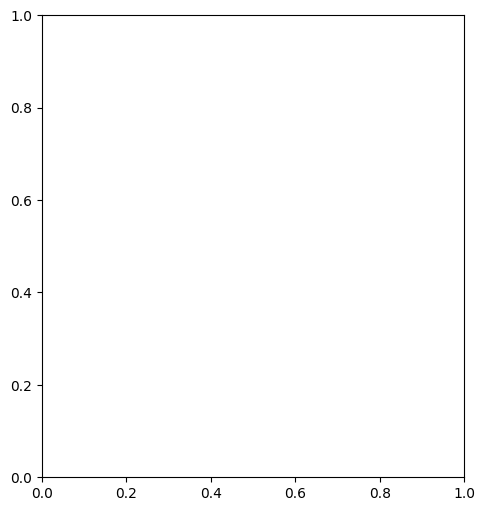

In [12]:
# alternatively, build the model with the optimal hyperparameters 
# best_model_band  = band_tuner.hypermodel.build(best_hps_band)
history_band = best_model_band.fit([event_encode, sequence_encode],y_encode, epochs=200, batch_size=best_hps_band.get('batch_size'), validation_split=0.2, callbacks=[early_stopping])

val_acc_per_epoch_band = history_band.history['val_accuracy']
best_epoch_band = val_acc_per_epoch_band.index(max(val_acc_per_epoch_band)) + 1
print('Best epoch: %d' % (best_epoch_band,))
print('Best Accuracy: ', max(val_acc_per_epoch_band))

# Evaluate the best model
#loss, accuracy = best_model_band.evaluate([event_encode, sequence_encode],y_encode)
#print('Test accuracy:', accuracy)

print_best_hp(best_hps_band)

plot_training_history_lstm(history_band.history)

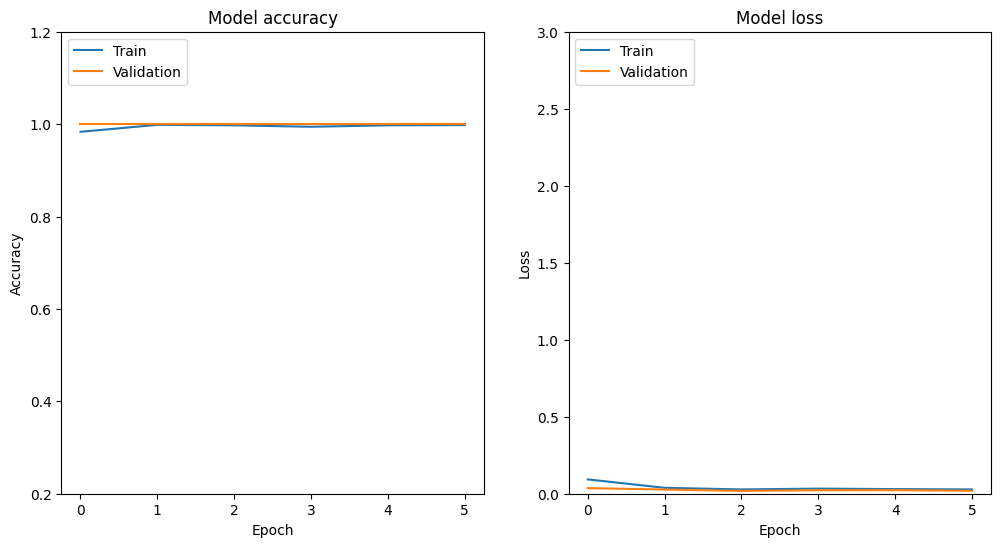

In [19]:
plot_training_history_lstm(history_band.history)

In [ ]:
# RandomSearch
tuner_rand= RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=300,
    executions_per_trial=2,
    directory='hparam_tuning',
    project_name='classfication_2levelfeatures_rand_bpi12o',
    hyperparameters=hp_b
)

tuner_rand.search(x=[event_encode, sequence_encode], y = y_encode,\
             epochs=300, validation_split=0.2, callbacks=[early_stopping])

# Get the best models and hyperparameters after search is randed
best_model_rand = tuner_rand.get_best_models(num_models=1)[0]
best_hps_rand = tuner_rand.get_best_hyperparameters(num_trials=1)[0]

# Fit the best model with the optimal batch size
best_model_rand.fit(
    [event_encode, sequence_encode],
    y_encode,
    epochs=300,
    batch_size=best_hps_rand.get('batch_size'),  # Use the best batch size found
    validation_split=0.2
)

# Evaluate the best model
loss, accuracy = best_model_rand.evaluate([event_encode, sequence_encode], y_encode)
print('Test accuracy:', accuracy)
print_best_hp(best_hps_rand)
#print_best_hp(best_hps)
best_model_rand.summary()

In [17]:
model = create_combined_lstm_model(event_input_shape, num_sequence_features, num_classes, lstm_units=128, dropout_rate=0.2)
history = model.fit([event_encode, sequence_encode],y_encode, epochs=300, batch_size=16, validation_split=0.2)

Epoch 1/300
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8231 - loss: 3.6360 - val_accuracy: 1.0000 - val_loss: 0.2123
Epoch 2/300
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9978 - loss: 0.1892 - val_accuracy: 1.0000 - val_loss: 0.1029
Epoch 3/300
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9992 - loss: 0.1068 - val_accuracy: 1.0000 - val_loss: 0.0764
Epoch 4/300
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9979 - loss: 0.0915 - val_accuracy: 1.0000 - val_loss: 0.0618
Epoch 5/300
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9996 - loss: 0.0720 - val_accuracy: 1.0000 - val_loss: 0.1215
Epoch 6/300
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9999 - loss: 0.0807 - val_accuracy: 1.0000 - val_loss: 0.0841
Epoch 7/300
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9995 - loss: 0.0636 - val_accuracy: 1.0000 - val_loss: 0.0489
Epoch 8/300
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9995 - loss: 0.0567 - val_accu

In [16]:
def create_combined_lstm_model(event_input_shape, num_sequence_features, num_classes, lstm_units=128, dropout_rate = 0.2):
    
    """
    Create and compile an LSTM model for classification.
    
    Parameters:
    - event_input_shape: Tuple representing the shape of the input data (sequence_length, number_of_features).
    - num_sequence_features: Interger represnting the number of sequence level feature
    - num_classes: Integer representing the number of target classes.
    - lstm_units: Integer representing the number of units in LSTM layers.
    - dropout_rate: Float between 0 and 1 representing the dropout rate for regularization.
    
    Returns:
    - Compiled Keras model ready for training.
    """    
    # Event-level input: Sequential data for LSTM processing
    event_input = Input(shape= event_input_shape, name='event_input')
    x = Masking(mask_value=-1.0)(event_input)
    # LSTM layers processing event-level features
    #lstm0_out = LSTM(lstm_units, return_sequences=True)(event_input)
    lstm0_out = LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(0.02))(x)
    lstm0_out = Dropout(dropout_rate)(lstm0_out)
    #lstm1_out = LSTM(int(lstm_units / 2), return_sequences=True)(lstm0_out)
    #lstm1_out = Dropout(dropout_rate)(lstm1_out)
    # Additional LSTM layer
    #lstm_out = LSTM(int(lstm_units / 2), return_sequences=False, kernel_regularizer=l2(0.02))(lstm0_out)  # Set return_sequences=False on the last LSTM layer
    #lstm_out = Dropout(dropout_rate)(lstm_out)

    # Sequence-level input: Static context features for the whole sequence
    sequence_input = Input(shape=(num_sequence_features,), name='sequence_input')

    # Concatenate LSTM output with sequence-level features
    concatenated = Concatenate()([lstm0_out, sequence_input])

    # Dense layer(s) after concatenation
    dense0_out = Dense(lstm_units, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
    dense0_out = Dropout(dropout_rate)(dense0_out)
    #dense1_out = Dense(int(lstm_units/2), activation='relu')(dense0_out)  # Additional dense layer
    #dense1_out = Dropout(dropout_rate)(dense1_out)
    #dense_out = Dense(int(lstm_units/4), activation='relu')(dense1_out)  # Additional dense layer
    #dense_out = Dropout(dropout_rate)(dense_out)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(dense0_out)

    # Build and compile the model
    model = Model(inputs=[event_input, sequence_input], outputs=output)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
plot_training_history(history)

In [ ]:
plot_training_history_smooth(history)